In [1]:
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt

In [2]:
import torch
import sys

In [3]:
from model.utils import choose_xy_ranges, choose_t_start, preprocessing_spd, preprocessing_spd_final, well_coordinates
from model.utils import show_target_rates, show_layers, plot_rates, plot_lambdas_vs_time, plot_weight_map
from model.utils import plot_sweep_efficiency

In [4]:
from model.crm import CRM, CRMP, CRMPWF

In [5]:
from tqdm.notebook import tqdm

In [48]:
# my_data22 = pd.read_excel('5x4_case_4_GTM (P2).xlsx', 'Sheet1')

In [61]:
# my_data22 = pd.read_excel('Synthetic_cases.xlsx', '1x4Pwf2')

In [343]:
# my_data22 = pd.read_excel('Synthetic_cases.xlsx', '1x4GTM')

In [10597]:
# my_data22 = pd.read_excel('1x4_st_upd.xlsx', 'Sheet1')

In [6]:
my_data22 = pd.read_excel('Synthetic_cases.xlsx', '5x4Old')

In [7]:
injectors = [item for item in my_data22.columns if 'inj' in item.lower()]
liq_producers = [item for item in my_data22.columns if 'liq' in item.lower()]
oil_producers = [item for item in my_data22.columns if 'oil' in item.lower()]
water_producers = [item for item in my_data22.columns if 'wat' in item.lower()]
bhp = [item for item in my_data22.columns if 'pwf' in item.lower()]

In [11033]:
# injectors = [item for item in my_data.columns if 'i' in item.lower()]
# liq_producers = [item for item in my_data.columns if 'p' in item.lower()]
# oil_producers = [item for item in my_data.columns if 'oil' in item.lower()]
# water_producers = [item for item in my_data.columns if 'wat' in item.lower()]
# bhp = [item for item in my_data.columns if 'pwf' in item.lower()]

In [8]:
inj_input22 = my_data22[injectors].values
liq_output22 = my_data22[liq_producers].values
oil_output22 = my_data22[oil_producers].values
water_output22 = my_data22[water_producers].values
pwf22 = my_data22[bhp].values

In [12]:
my_data22

Date     Inj01     Inj02     Inj03     Inj04     Inj05      Liq01  \
0   2005-12-31     0.000     0.000     0.000     0.000     0.000     0.0000   
1   2006-01-30   275.216  1819.570   279.949   268.657   770.142   705.1340   
2   2006-03-01   543.228  1367.660   923.145   630.277   503.555  1085.3872   
3   2006-03-31  2713.260   627.234   965.912   606.397  1050.950  3174.5710   
4   2006-04-30  3543.230   300.426   773.641   568.870  1018.960  3943.0700   
..         ...       ...       ...       ...       ...       ...        ...   
96  2013-11-19  2341.500  1056.170  1379.500  1130.060  1139.810  3157.4930   
97  2013-12-19  2557.640  1033.190  1377.400  1051.600  1427.730  3373.8150   
98  2014-01-18  2505.760  1245.110  1454.350   797.441  1242.890  3373.8100   
99  2014-02-17  2704.610  1377.870  1187.300   638.806  1214.450  3590.1370   
100 2014-03-19  2998.560  1533.620  1294.170   962.900  1093.600  3943.0770   

        Liq02     Liq03       Liq04  ...  Pwf03  Pwf04     Oil01     Oil02  \
0      0.0000    0.0000     0.00000  ...    250    250     0.000    0.0000   
1     52.6766  130.9910   754.46457  ...    100    100   704.934   52.1366   
2     63.3239  203.8340  1528.27500  ...    100    100  1029.410   62.7839   
3     85.1414  242.1730  1796.12600  ...    100    100   961.101   84.6014   
4    100.5740  253.6750  1781.25000  ...    100    100   477.230  100.0340   
..        ...       ...         ...  ...    ...    ...       ...       ...   
96   226.7156  392.9717  3202.37700  ...    100    100   221.063   16.8196   
97   221.4137  414.6966  3254.46700  ...    100    100   203.985   15.7647   
98   205.4735  432.5876  3291.66700  ...    100    100   192.600   13.6445   
99   186.8740  450.4796  2971.72500  ...    100    100   186.907   13.6550   
100  185.1060  463.2587  3083.33500  ...    100    100   186.907   10.2810   

        Oil03     Oil04    Water01  Water02  Water03     Water04  
0      0.0000     0.000     0.0000    0.000    0.000     0.00000  
1    130.6710   745.536     0.2000    0.540    0.320     8.92857  
2    203.5140  1258.930    55.9772    0.540    0.320   269.34500  
3    241.8530  1043.150  2213.4700    0.540    0.320   752.97600  
4    253.3550   968.750  3465.8400    0.540    0.320   812.50000  
..        ...       ...        ...      ...      ...         ...  
96    52.7157   135.417  2936.4300  209.896  340.256  3066.96000  
97    53.9936   135.417  3169.8300  205.649  360.703  3119.05000  
98    53.9936   135.417  3181.2100  191.829  378.594  3156.25000  
99    53.9936   105.655  3403.2300  173.219  396.486  2866.07000  
100   51.4377   113.095  3756.1700  174.825  411.821  2970.24000  

[101 rows x 22 columns]

In [9]:
dates22 = pd.to_datetime(my_data22['Date'])

In [409]:
# dates22 = pd.Series(pd.date_range('2010-01-01','2028-06-01' , freq='1M').values)
# dates22 = dates[:my_data.shape[0]]

In [19]:
# prod_ind22 = [0, 1, 2, 3]
# inj_ind22 = [0]
# t_start = 100
# t_train = 220
# mymodel22 = CRMP(t_start, t_train, 30, dates22, inj_input22[:, inj_ind22],
#                liq_output22[:, prod_ind22], pwf22[:, prod_ind22], bhp_term=True, # pwf22[:, prod_ind22]
#                well_distances=[None, None],
#                radius_for_accounting=[None, None], gtm_info=None, aquifer=False, lambda_matbal=False)

In [410]:
oil_output22.shape

(101, 4)

In [10]:
prod_ind22 = [0, 1, 2, 3]
inj_ind22 = [0, 1, 2, 3, 4]
t_start = 1
t_train = 75
mymodel22 = CRMP(t_start, t_train, 30, dates22, inj_input22[:, inj_ind22],
               liq_output22[:, prod_ind22], pwf22[:, prod_ind22], bhp_term=True, # pwf22[:, prod_ind22]
               well_distances=[None, None],
               radius_for_accounting=[None, None], gtm_info=None, aquifer=False, lambda_matbal=False)

In [11]:
%%time
_ = mymodel22.optimize(fluids='liq', constraints=True)

CPU times: user 57.2 s, sys: 1.01 s, total: 58.2 s
Wall time: 3 s


In [12]:
# mymodel22.set_sat_start(np.array([0.25, 0.15, 0.15, 0.15]))

In [13]:
mymodel22.add_ffm(t_start, t_train, oil_output22[:, prod_ind22], water_output22[:, prod_ind22])#, dtype='BL')

In [14]:
%%time
_ = mymodel22.optimize(fluids='oil', constraints=True)

CPU times: user 115 ms, sys: 586 µs, total: 115 ms
Wall time: 17.2 ms


In [302]:
%%time
_ = mymodel22.optimize(fluids='oil', opt_type='Nelder-Mead', constraints=True, x0_weights=mymodel22.ff_weights)

CPU times: user 986 ms, sys: 0 ns, total: 986 ms
Wall time: 984 ms


In [22]:
# %debug

In [48]:
mymodel22.sor_weights

array([0.36886847, 0.4       , 0.2797511 , 0.39976363])

In [ ]:
2/24/2007
7/18/2008
2/8/2010
7/3/2011

In [89]:
np.where(dates22 == pd.to_datetime('2/24/2007'))

(array([14]),)

In [ ]:
[[14, 0], [31, 0], [50, 0], [67, 0]]

In [760]:
prod_ind22 = [0, 1, 2, 3]
inj_ind22 = [0, 1, 2, 3, 4]
t_start = 1
t_train = 85
mymodel22 = CRMP(t_start, t_train, 30, dates22, inj_input22[:, inj_ind22],
               liq_output22[:, prod_ind22], None, bhp_term=False,
               well_distances=[None, None],
               radius_for_accounting=[None, None], gtm_info=[[14, 1], [31, 1], [50, 1], [67, 1]],
                 aquifer=False, lambda_matbal=False)

In [154]:
mymodel22.gtm_info

In [35]:
%%time
_ = mymodel22.optimize(fluids='liq', constraints=True)

CPU times: user 2.2 s, sys: 29 ms, total: 2.23 s
Wall time: 2.23 s


 active_mask: array([ 0,  0,  1,  1,  0,  0,  0,  0,  1,  0, -1,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0])
        cost: 540181.4875471651
         fun: array([-8.47845781e-02, -5.31901093e+00, -8.09734502e-11, -1.13686838e-13,
        2.77893304e+02,  6.09935592e+00, -2.90961589e+00, -1.80830566e+02,
        1.08772989e+02,  2.13209476e+00, -3.70712277e+00,  1.75273990e+01,
        2.88774306e+01, -2.48506859e+00, -8.41013661e+00,  1.41050285e+02,
        2.52958983e+02, -1.17594748e+00,  1.04738165e+01,  1.32025130e+02,
        1.51914400e+02, -9.19046729e-01,  1.13686121e+00, -3.10808442e+01,
       -1.88434974e+01, -1.23728731e-01, -7.04660454e+00, -6.77629886e+01,
       -3.02990013e+01, -8.85282864e-01, -7.93104317e+00, -3.20540434e+01,
       -6.91279391e+01, -2.26551946e+00, -3.28188013e+00, -1.16638927e+01,
        8.94704487e+01,  2.19056172e+00,  6.58630823e+00,  3.97934883e+01,
        9.26758659e+01, 

In [677]:
# %debug

In [15]:
# mymodel22.init_optim_problem(t_train, mymodel22.t_max-1)

In [16]:
# mymodel22.init_prime_rates(liq_output22[t_train])

In [17]:
# mymodel22.run_optim_problem()

In [18]:
# %debug

In [42]:
# inj_ind_optim_problem = 2

# plt.plot((mymodel22.inj_max_vals*mymodel22.inj_optim_coeffs)[:, inj_ind_optim_problem], label='Inj optim')
# plt.plot(inj_input22[t_train+1:, inj_ind_optim_problem], label='Inj orig')
# plt.legend()
# plt.grid()
# plt.show()

In [41]:
# prod_ind_optim_problem = 2

# plt.plot(mymodel22.liquid_rates2[:, prod_ind_optim_problem], label='Liq optim')
# plt.plot(liq_output22[t_train:, prod_ind_optim_problem], label='Liq orig')
# plt.legend()
# plt.grid()
# plt.show()

In [40]:
# prod_ind_optim_problem = 0

# plt.plot(mymodel22.oil_rates2[:, prod_ind_optim_problem], label='Oil optim')
# plt.plot(oil_output22[t_train+1:, prod_ind_optim_problem], label='Oil orig')
# # plt.plot(wat_output[114+1:, prod_ind_optim_problem])
# plt.legend()
# plt.grid()
# plt.show()

In [39]:
# plt.plot(np.hstack((oil_output22[t_train+1:, prod_ind_optim_problem], mymodel22.oil_rates2[:, prod_ind_optim_problem])))

In [38]:
# mymodel22.lambdas_vs_time[-3]

In [43]:
# mymodel22.inj_optim_coeffs

In [326]:
# %debug

In [26]:
cum_inj = (mymodel22.lambdas_vs_time[t_start+1:]*mymodel22.injection_rates[t_start+1:]*
           mymodel22.dt[t_start+1:, None, None]*mymodel22.timestamp).cumsum(0).sum(1)

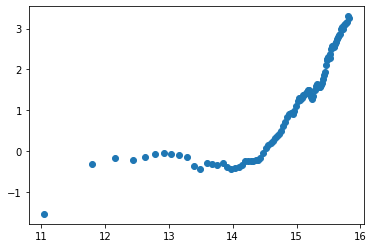

In [33]:
iiind = 3

plt.scatter(np.log(cum_inj)[:, iiind], np.log(liq_output22[t_start+1:, iiind]/oil_output22[t_start+1:, iiind] - 1.))

In [44]:
liq_preds22 = mymodel22.predict_liq(t_start, mymodel22.t_max-1)

In [45]:
oil_preds22 = mymodel22.predict_oil(t_start, mymodel22.t_max-1, liq_preds22[:])

In [46]:
mymodel22.tau_prime

array([0.01889511, 2.16366663, 4.09003524, 1.21928853])

In [47]:
mymodel22.tau_weights.round(3)

array([[0.274, 2.868, 3.085, 1.437]])

In [48]:
mymodel22.J_pwf.round(3)

array([[11.35 ,  0.078,  0.095,  1.655]])

In [49]:
mymodel22.lambda_weights.round(3).sum(1)

array([1.025, 0.916, 1.151, 1.018, 0.955])

In [50]:
mymodel22.a_weights

array([ 7.47601069, 40.82157547, 41.29033076,  2.51277582])

In [51]:
mymodel22.b_weights

array([4.29872191, 0.11095017, 0.84207692, 3.79736121])

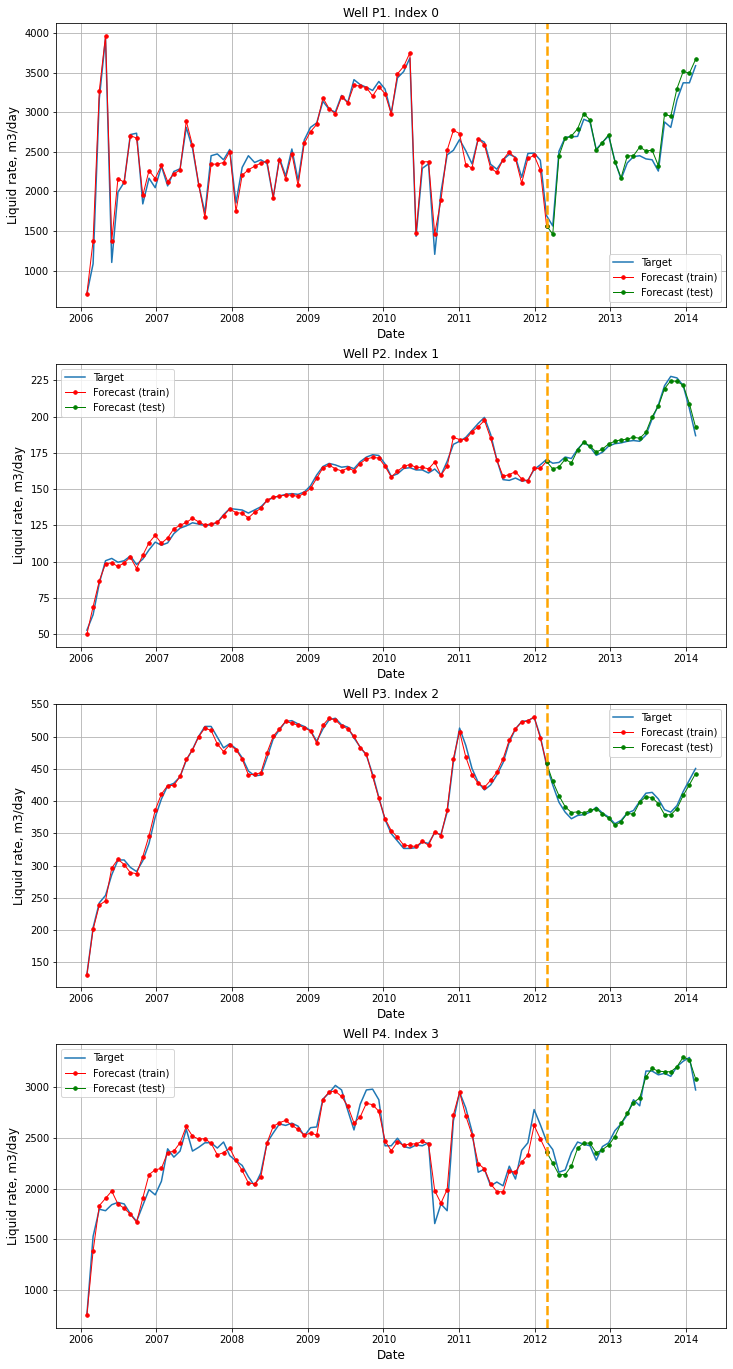

In [53]:
plot_rates(t_start, t_train, mymodel22.t_max-1, dates22, liq_output22, liq_preds22, ['P1', 'P2', 'P3', 'P4'])#,
#            wos=[[14, 1], [31, 1], [50, 1], [67, 1]])

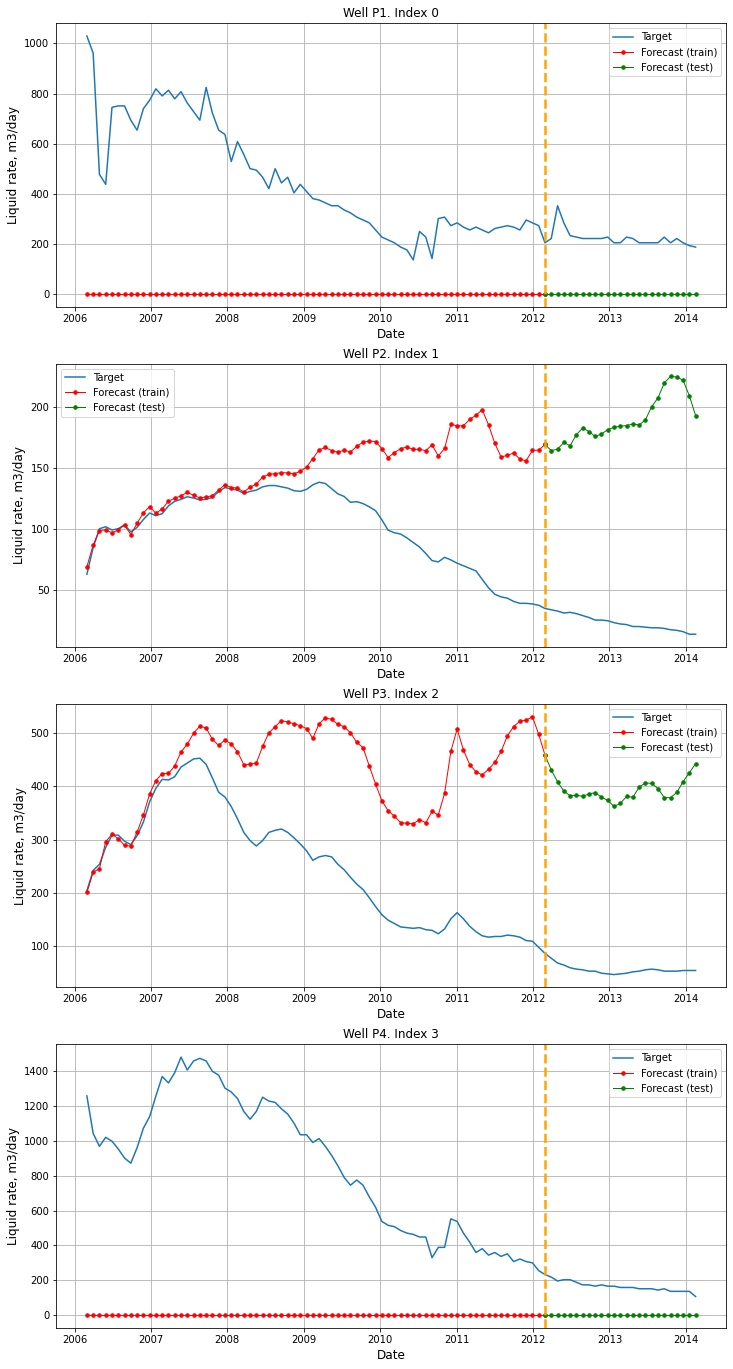

In [54]:
plot_rates(t_start+1, t_train, mymodel22.t_max-1, dates22, oil_output22, oil_preds22[:], ['P1', 'P2', 'P3' ,'P4'])#,
#            wos=[[14, 1], [31, 1], [50, 1], [67, 1]])

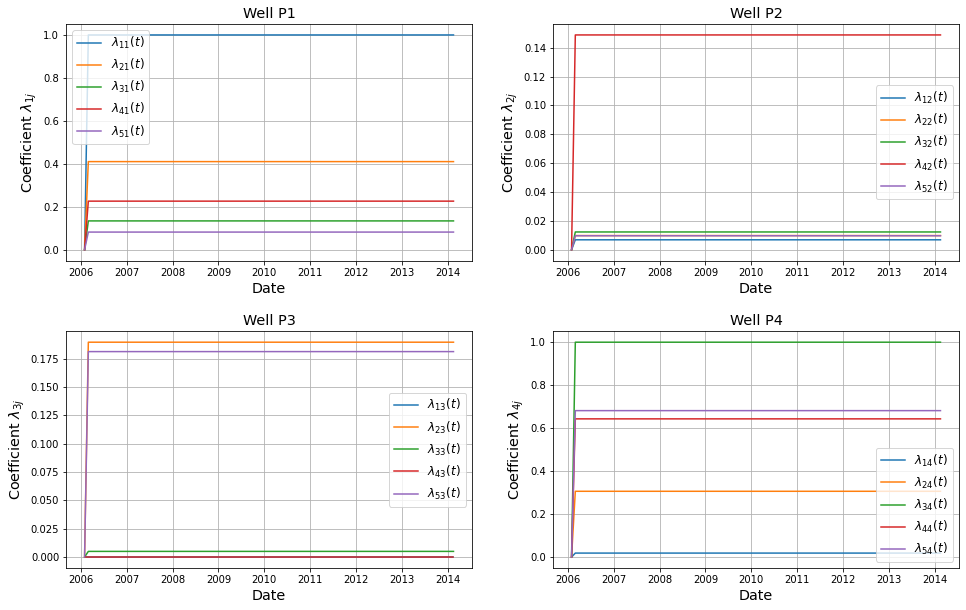

In [55]:
plot_lambdas_vs_time(t_start, mymodel22.t_max-1, dates22, mymodel22.lambdas_vs_time, ['P1', 'P2', 'P3' ,'P4'], lang='Eng')

In [56]:
prod_wells22 = np.array(['P01', 'P02', 'P03', 'P04'])
inj_wells22 = np.array(['I01', 'I02', 'I03', 'I04', 'I05'])

In [57]:
prod_ind22, inj_ind22 = np.arange(4), np.arange(5)

In [58]:
inj_wells_coords22 = np.array([[-150., 150.], [150., 150.], [0., 0.], [-150., -150.], [150., -150.]])

In [59]:
prod_wells_coords22 = np.array([[0., 150], [-150, 0.], [150, 0.], [0., -150]])

In [60]:
prod_inj_distances22 = np.array([[(((xy_prod - xy_inj)**2).sum())**0.5 for xy_prod in prod_wells_coords22]
                               for xy_inj in inj_wells_coords22])
prod_prod_distances22 = np.array([[(((xy_prod - xy_prod2)**2).sum())**0.5 for xy_prod in prod_wells_coords22]
                                for xy_prod2 in prod_wells_coords22])

In [1689]:
# prod_wells_coords22 = np.array([inj_wells_coords22[0] + np.array([2**0.5/2*1000., 2**0.5/2*1000.]),
# inj_wells_coords22[0] + np.array([-2**0.5/2*1000., 2**0.5/2*1000.]),
# inj_wells_coords22[0] + np.array([-2**0.5/2*1000., -2**0.5/2*1000.]),
# inj_wells_coords22[0] + np.array([2**0.5/2*1000., -2**0.5/2*1000.])])

In [10946]:
# inj_wells_coords22 = np.array([[0., 0.]])

In [63]:
plot_weight_map(mymodel22.lambdas_vs_time, prod_wells22[prod_ind22], inj_wells22[inj_ind22],
                prod_wells_coords22[prod_ind22], inj_wells_coords22[inj_ind22], prod_inj_distances22,
                1000., bound_vals=(0.0, 1.0), r2_vals=None)

interactive(children=(IntSlider(value=0, description='timestep'), Output()), _dom_classes=('widget-interact',)…

In [67]:
plot_sweep_efficiency(mymodel22.lambdas_vs_time, prod_wells22[prod_ind22], inj_wells22[inj_ind22],
                      prod_wells_coords22[prod_ind22], inj_wells_coords22[inj_ind22])

interactive(children=(IntSlider(value=100, description='t:'), Output()), _dom_classes=('widget-interact',))

In [1226]:
%matplotlib inline

In [1227]:
from IPython.display import HTML

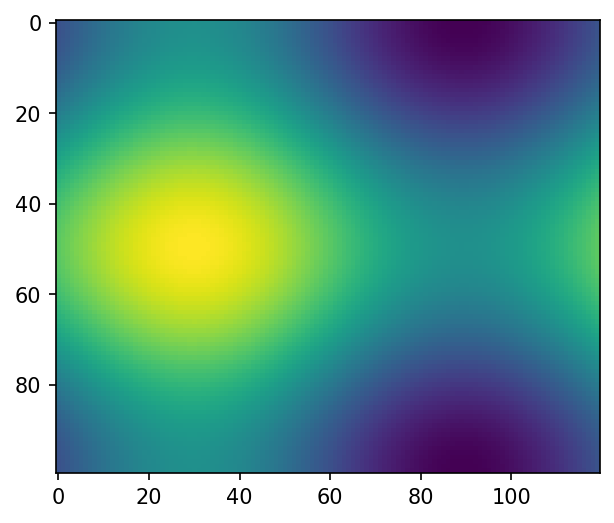

In [1221]:
fig, ax = plt.subplots()

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

HTML(ani.to_jshtml())

In [1214]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
xdata, ydata = [], []
ln, = plt.plot([], [], 'ro')

def init():
    ax.set_xlim(0, 2*np.pi)
    ax.set_ylim(-1, 1)
    return ln,

def update(frame):
    xdata.append(frame)
    ydata.append(np.sin(frame))
    ln.set_data(xdata, ydata)
    return ln,

ani = FuncAnimation(fig, update, frames=np.linspace(0, 2*np.pi, 128),
                    init_func=init, blit=True)
plt.show()

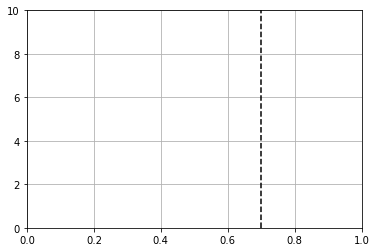

In [1148]:
import math

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


def beta_pdf(x, a, b):
    return (x**(a-1) * (1-x)**(b-1) * math.gamma(a + b)
            / (math.gamma(a) * math.gamma(b)))


class UpdateDist:
    def __init__(self, ax, prob=0.5):
        self.success = 0
        self.prob = prob
        self.line, = ax.plot([], [], 'k-')
        self.x = np.linspace(0, 1, 200)
        self.ax = ax

        # Set up plot parameters
        self.ax.set_xlim(0, 1)
        self.ax.set_ylim(0, 10)
        self.ax.grid(True)

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.
        self.ax.axvline(prob, linestyle='--', color='black')

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            self.success = 0
            self.line.set_data([], [])
            return self.line,

        # Choose success based on exceed a threshold with a uniform pick
        if np.random.rand(1,) < self.prob:
            self.success += 1
        y = beta_pdf(self.x, self.success + 1, (i - self.success) + 1)
        self.line.set_data(self.x, y)
        return self.line,

# Fixing random state for reproducibility
np.random.seed(19680801)


fig, ax = plt.subplots()
ud = UpdateDist(ax, prob=0.7)
anim = FuncAnimation(fig, ud, frames=100, interval=100, blit=True)
plt.show()

In [121]:
from matplotlib.animation import FuncAnimation

In [119]:
from IPython.display import HTML

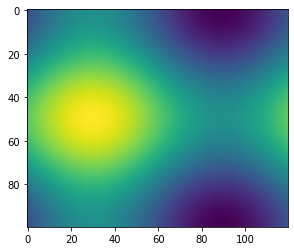

In [125]:
fig, ax = plt.subplots()

def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15.
    y += np.pi / 20.
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = matplotlib.animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

# To save the animation, use e.g.
#
# ani.save("movie.mp4")
#
# or
#
# writer = animation.FFMpegWriter(
#     fps=15, metadata=dict(artist='Me'), bitrate=1800)
# ani.save("movie.mp4", writer=writer)

HTML(ani.to_jshtml())